In [1]:
%config Completer.use_jedi = False

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import yaml 
import glob
import math

from scipy.stats import spearmanr

In [2]:
with open('/data/hookbill/hadfield/syntheticVS/data/EGNN_attribution_dfs/attribution_df_pdbbind_small_hydrophobic.yaml', 'r') as f:
    egnn_zinc_dfs = yaml.load(f, Loader=yaml.Loader)

In [3]:
def load_yaml(fname):
    
    with open(fname, 'r') as f:
        y = yaml.load(f, Loader=yaml.Loader)
        
    for k in y.keys():
        y[k] = pd.DataFrame(y[k])
        y[k].columns = ['x', 'y', 'z', 'atomic_num', 'atom_type', 'lig', 'attrbution', 'binding']
        
    return y
    

In [4]:
egnn_zinc_dfs = load_yaml('/data/hookbill/hadfield/syntheticVS/data/EGNN_attribution_dfs/attribution_df_zinc_Masking.yaml')
egnn_pdbbind_dfs = load_yaml('/data/hookbill/hadfield/syntheticVS/data/EGNN_attribution_dfs/attribution_df_pdbbind_small_hydrophobic.yaml')

In [54]:
egnn_pdbbind_dfs_200k = load_yaml('/data/hookbill/hadfield/syntheticVS/data/EGNN_attribution_dfs/attribution_df_pdbbind_small_hydrophobic_200k.yaml')

In [5]:
rf_pdbbind_dfs = {}
rf_pdbbind_correlations = {}

for pc in ['25', '3', '35', '4', '45', '5', '55', '6']:
    rf_pdbbind_dfs[pc] = [pd.read_csv(x, sep = ' ') for x in glob.glob(f'/data/hookbill/hadfield/syntheticVS/data/pdbbind_small_hydrophobic_filtered_test_set/attributions_dir_{pc}/df*.csv')]

    correlations_vec = [spearmanr(x['attribution'], x['binding']).correlation for x in rf_pdbbind_dfs[pc]]
    print(sum([math.isnan(x) for x in correlations_vec]))
    
    rf_pdbbind_correlations[pc] = np.nanmean(correlations_vec)
    print(pc, rf_pdbbind_correlations[pc])
    

/data/hookbill/hadfield/anaconda3/envs/DeLinker-env/lib/python3.6/site-packages/numpy/lib/function_base.py:2400: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/data/hookbill/hadfield/anaconda3/envs/DeLinker-env/lib/python3.6/site-packages/numpy/lib/function_base.py:2401: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
/data/hookbill/hadfield/anaconda3/envs/DeLinker-env/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
/data/hookbill/hadfield/anaconda3/envs/DeLinker-env/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
/data/hookbill/hadfield/anaconda3/envs/DeLinker-env/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:1821: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond

76
25 0.0062358489577614105
15
3 0.027295577622364044
37
35 0.03861486495709621
0
4 0.04610715082794234
0
45 0.08239568801277086
0
5 0.08655416609106577
0
55 0.0625726513369903
0
6 0.09305331146503187


In [6]:
#rf_pdbbind_dfs_fnames = glob.glob('/data/hookbill/hadfield/syntheticVS/data/pdbbind_filtered_test_set_hydrophobic/attribution_dfs/df*.csv')
#rf_pdbbind_dfs = [pd.read_csv(x, sep = ' ') for x in rf_pdbbind_dfs_fnames]


rf_zinc_dfs_fnames = glob.glob('/data/hookbill/hadfield/syntheticVS/data/zinc_hydrophobic_forced_50ops_ac0025_st4_split/attribution_dfs/df*.csv')
rf_zinc_dfs = [pd.read_csv(x, sep = ' ') for x in rf_zinc_dfs_fnames]
print(len(rf_zinc_dfs_fnames))

2005


In [7]:
rf_pdbbind_dfs[0]

KeyError: 0

In [8]:
def avg_rank_above_threshold(threshold, df, sort_by_binding = False, random_ranking = False):
    
    if sort_by_binding:
        df = df.sort_values('binding', ascending = False).reset_index(drop=True)
    
    if random_ranking:
        df['random'] = np.random.uniform(size=df.shape[0])
        df = df.sort_values('random', ascending = False).reset_index(drop=True)
    
    above_df = df.loc[df['binding'] > threshold]
    
    indices_above_threshold = list(above_df.index)
    indices_above_threshold = [x + 1 for x in indices_above_threshold]
    
    if len(indices_above_threshold) == 0:
        return -1
    else:
        return np.mean(indices_above_threshold)

def get_high_rank_sum_stat(df_list, thresholds, sort_by_binding = False, random_ranking = False):
    
    all_thresholds = []
    
    for t in thresholds:
        
        df_ranks = []
        
        for df in df_list:
            single_example = avg_rank_above_threshold(t, df, sort_by_binding, random_ranking)
            if single_example != -1:
                df_ranks.append(single_example)
            
        all_thresholds.append(np.mean(df_ranks))
    
    return all_thresholds

In [9]:
test = egnn_pdbbind_dfs[20]
list(test.loc[test['binding'] > 1].index)

[0, 1, 2]

In [10]:
avg_rank_stat_pdbbind_egnn = get_high_rank_sum_stat(list(egnn_pdbbind_dfs.values()), np.arange(0.5, 3, 0.05))
#avg_rank_stat_pdbbind_rf = get_high_rank_sum_stat(rf_pdbbind_dfs, np.arange(0.5, 3, 0.05))

avg_rank_stat_pdbbind_rf = {}


for pc in ['25', '3', '35', '4', '45', '5', '55', '6']:

    avg_rank_stat_pdbbind_rf[pc] = get_high_rank_sum_stat(rf_pdbbind_dfs[pc], np.arange(0.5, 3, 0.05))
    


In [11]:
avg_rank_stat_pdbbind_egnn_200k = get_high_rank_sum_stat(list(egnn_pdbbind_dfs_200k.values()), np.arange(0.5, 3, 0.05))


NameError: name 'egnn_pdbbind_dfs_200k' is not defined

In [12]:
avg_rank_stat_pdbbind_egnn_best = get_high_rank_sum_stat(list(egnn_pdbbind_dfs.values()), np.arange(0.5, 3, 0.05), sort_by_binding=True)
avg_rank_stat_pdbbind_egnn_baseline = get_high_rank_sum_stat(list(egnn_pdbbind_dfs.values()), np.arange(0.5, 3, 0.05), random_ranking=True)



In [13]:
avg_rank_stat_pdbbind_egnn_200k

NameError: name 'avg_rank_stat_pdbbind_egnn_200k' is not defined

In [14]:
#avg_rank_stat_zinc_egnn = get_high_rank_sum_stat(list(egnn_zinc_dfs.values()), np.arange(0.5, 3, 0.05))
avg_rank_stat_zinc_rf = get_high_rank_sum_stat(rf_zinc_dfs, np.arange(0.5, 3, 0.05))


KeyboardInterrupt: 

In [ ]:
avg_rank_stat_zinc_rf

0 25 4
1 3 5
2 35 6
3 4 7
4 45 8
5 5 9
6 55 10
7 6 11


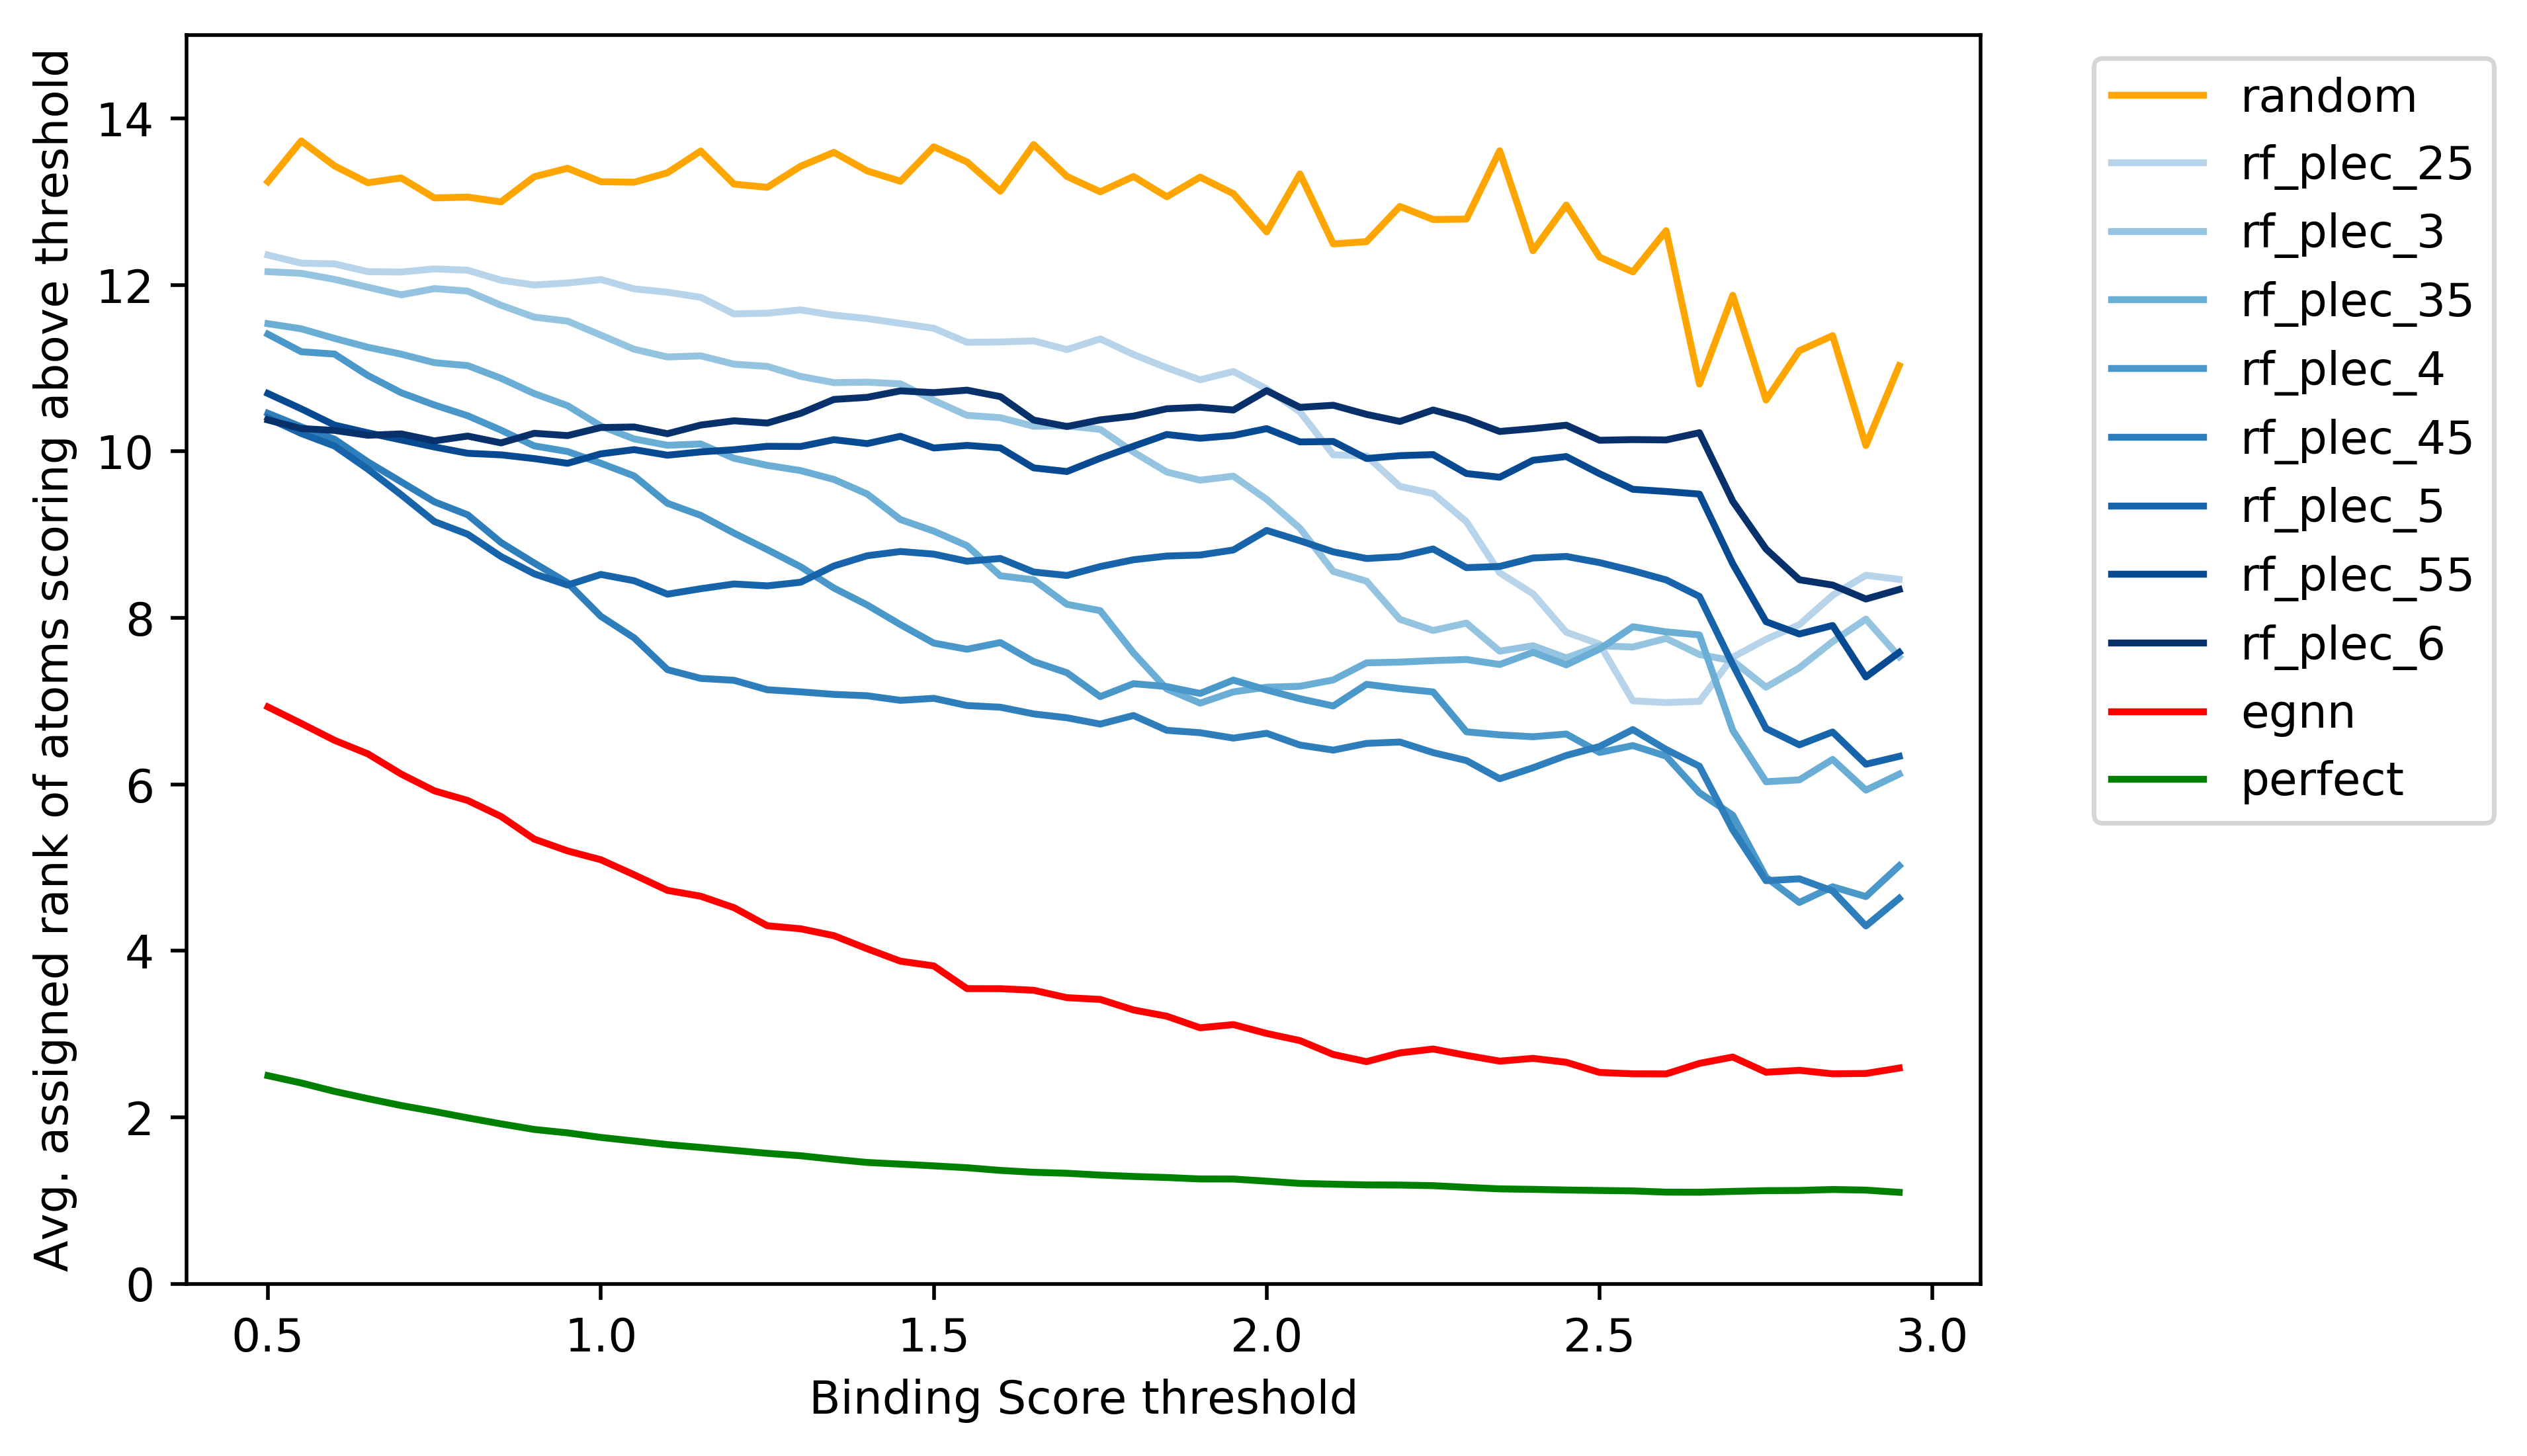

In [43]:
import matplotlib as mpl
c = np.arange(1, len(avg_rank_stat_pdbbind_rf.keys()) + 4)

norm = mpl.colors.Normalize(vmin=c.min(), vmax=c.max())
cmap = mpl.cm.ScalarMappable(norm=norm, cmap=mpl.cm.Blues)
cmap.set_array([])


plt.figure(figsize = (7,5), dpi=500)

#plt.plot(np.arange(0.5, 3, 0.05), avg_rank_stat_pdbbind_egnn_200k, label = 'egnn_200k')

#plt.plot(np.arange(0.5, 3, 0.05), avg_rank_stat_pdbbind_rf, label = 'rf')


plt.plot(np.arange(0.5, 3, 0.05), avg_rank_stat_pdbbind_egnn_baseline, label = 'random', color = 'orange')


for i, pc in enumerate(avg_rank_stat_pdbbind_rf.keys()):
    print(i, pc, i + 4)
    plt.plot(np.arange(0.5, 3, 0.05), avg_rank_stat_pdbbind_rf[pc], label = f'rf_plec_{pc}', color=cmap.to_rgba(i + 4))

plt.plot(np.arange(0.5, 3, 0.05), avg_rank_stat_pdbbind_egnn, label = 'egnn', color = 'red')
plt.plot(np.arange(0.5, 3, 0.05), avg_rank_stat_pdbbind_egnn_best, label = 'perfect', color = 'green')    
    
plt.ylim((0,15))
plt.xlabel('Binding Score threshold')
plt.ylabel('Avg. assigned rank of atoms scoring above threshold')
#plt.legend()
plt.legend(bbox_to_anchor=(1.05, 1))

#plt.savefig('/data/hookbill/hadfield/syntheticVS/figures_for_paper/hydrophobic_attribution_2.png', bbox_inches='tight')
plt.show()


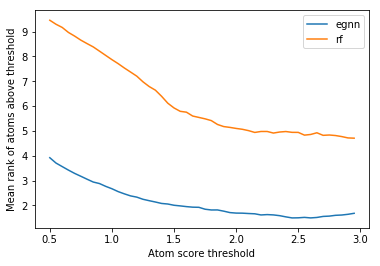

In [85]:
plt.plot(np.arange(0.5, 3, 0.05), avg_rank_stat_zinc_egnn, label = 'egnn')
plt.plot(np.arange(0.5, 3, 0.05), avg_rank_stat_zinc_rf, label = 'rf')
plt.xlabel('Atom score threshold')
plt.ylabel('Mean rank of atoms above threshold')
plt.legend()
plt.show()

In [42]:
rf_pdbbind_dfs['25'][0].sort_values('binding', ascending = False).reset_index(drop=True)

,atom_idx,x,y,z,attribution,binding
0,0,-1.4403,-2.5451,-1.3388,0.530199,2.628034
1,11,0.0160,1.9588,1.2998,0.530199,1.668288
2,13,-2.7151,1.6563,0.5504,0.530199,1.345478
3,15,-3.4237,-0.7203,-0.7044,0.530199,1.338088
4,7,4.5882,1.0573,-0.5997,0.530199,0.487414
5,5,2.7575,-0.8180,-0.1302,0.530199,0.266469
6,8,4.6540,-0.1345,1.6085,0.530199,0.252135
7,2,0.1173,-1.1082,-0.5565,0.530199,0.248848
8,9,5.3412,-1.3305,-0.4831,0.530199,0.090332
9,1,-1.1892,-1.5401,-0.4217,0.530199,0.000000
